###Importação de bibliotecas

In [1]:
import os

# Importações de visualização
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Importação para visualização de imagem
from PIL import Image, ImageOps
from tqdm import tqdm

# Importação para carregar o Dataset
import gdown
import zipfile
from google.colab import files
import shutil

In [ ]:
# Importações para tratamento de dados
import hashlib
import cv2
from sklearn.utils.class_weight import compute_class_weight
import pickle

###Carregamento do dataset

In [3]:
# Como este notebook é exclusivo para o tratamento de dados,
# apenas o dataset de treino será carregado
# além de simplificar o processo, o dataset de teste permaneceria intocado
# Esta parte é idêntica ao carregamento do notebook na EDA
file_id = "1IBC3mk83DnHkZ4Xn3Kq9H18kM3_WITx2"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}",
    "/content/chest_xray.zip",
    quiet=False,
)

with zipfile.ZipFile("/content/chest_xray.zip", "r") as zip_ref:
    zip_ref.extractall("/content/data_chest_xray")

print("Dataset carregado!")

Downloading...
From (original): https://drive.google.com/uc?id=1IBC3mk83DnHkZ4Xn3Kq9H18kM3_WITx2
From (redirected): https://drive.google.com/uc?id=1IBC3mk83DnHkZ4Xn3Kq9H18kM3_WITx2&confirm=t&uuid=34f0e9ee-9c19-48da-bc92-ed889b9a4e9e
To: /content/chest_xray.zip
100%|██████████| 1.26G/1.26G [00:18<00:00, 69.0MB/s]


Dataset carregado!


In [4]:
# Criação do dataframe de treino
rows_train = []
train_path = "/content/data_chest_xray/chest_xray/train"

for label in ["NORMAL", "PNEUMONIA"]:
    folder = os.path.join(train_path, label)

    if not os.path.exists(folder):
        continue

    for filename in os.listdir(folder):
        if filename.lower().endswith((".jpeg", ".jpg", ".png")):
            rows_train.append({
                "filepath": os.path.join(folder, filename),
                "filename": filename,
                "label": label,
                "label_bin": 0 if label == "NORMAL" else 1,
            })

df = pd.DataFrame(rows_train)
print(f"Treino: {len(df)} imagens")
print(df["label"].value_counts())

Treino: 5232 imagens
label
PNEUMONIA    3883
NORMAL       1349
Name: count, dtype: int64


In [5]:
# Checa se há duplicadas no dataset
def calcular_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

df['hash'] = df['filepath'].apply(calcular_hash)

duplicatas = df[df.duplicated(subset='hash', keep='first')]
print(f"Duplicatas encontradas: {len(duplicatas)}")
print(duplicatas[['filename', 'label']])

Duplicatas encontradas: 26
                        filename      label
680     NORMAL-3780378-0001.jpeg     NORMAL
2794     VIRUS-8276936-0004.jpeg  PNEUMONIA
2863  BACTERIA-4647402-0003.jpeg  PNEUMONIA
2867      VIRUS-463487-0012.jpeg  PNEUMONIA
3258  BACTERIA-6420973-0004.jpeg  PNEUMONIA
3365  BACTERIA-7718116-0005.jpeg  PNEUMONIA
3450   BACTERIA-828649-0005.jpeg  PNEUMONIA
3559  BACTERIA-6295192-0003.jpeg  PNEUMONIA
3646  BACTERIA-7721065-0006.jpeg  PNEUMONIA
3744  BACTERIA-7721065-0004.jpeg  PNEUMONIA
3767     VIRUS-9130179-0004.jpeg  PNEUMONIA
3915  BACTERIA-8054264-0004.jpeg  PNEUMONIA
3918  BACTERIA-4687423-0002.jpeg  PNEUMONIA
4242   BACTERIA-266879-0001.jpeg  PNEUMONIA
4375  BACTERIA-6660769-0005.jpeg  PNEUMONIA
4429  BACTERIA-7564600-0004.jpeg  PNEUMONIA
4451     VIRUS-6450342-0003.jpeg  PNEUMONIA
4533     VIRUS-5366209-0003.jpeg  PNEUMONIA
4554  BACTERIA-8034950-0012.jpeg  PNEUMONIA
4666  BACTERIA-6420973-0006.jpeg  PNEUMONIA
4704     VIRUS-1213217-0002.jpeg  PNEUMONIA
4735 

In [6]:
# Remoção das duplicatas
df = df.drop_duplicates(subset='hash', keep='first').reset_index(drop=True)
print(f"Dataset após remoção: {len(df)} imagens")

Dataset após remoção: 5206 imagens


Vale ressaltar que é interessante remover as duplicatas especialmente nesse caso, já que 25 das 26 duplicatas são de imagem com pneumonia. A permanência desses arquivos apenas reforçaria o desbalanceamento de classes e poderia comprometer a qualidade do treinamento do modelo.

###Conversão para escala L

In [7]:
# Como visto na EDA, há algumas imagens na escala RGB
# Para otimizar o processo, todas serão convertidas para a grayscale
# Uma vez que foram convertidas, serão adicionadas a outra pasta
output_dir = '/content/chest_xray_tratado/train'

for _, row in df.iterrows():
    img = Image.open(row['filepath']).convert('L')

    label_dir = os.path.join(output_dir, row['label'])
    os.makedirs(label_dir, exist_ok=True)

    dest = os.path.join(label_dir, row['filename'])
    img.save(dest)

print("Conversão concluída!")

Conversão concluída!


In [8]:
# Atualização do dataframme
df['filepath'] = df.apply(
    lambda row: os.path.join(output_dir, row['label'], row['filename']),
    axis=1,
    )

###Correção do brilho

In [9]:
# Definição do CLAHE
# Essa técnica foi escolhida por ser mais aplicada na área médica
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def corrigir_brilho(filepath):
    img = Image.open(filepath)
    arr = np.array(img)
    arr_corrigido = clahe.apply(arr)
    return Image.fromarray(arr_corrigido)

In [10]:
# Aplicação no dataset
output_dir = '/content/chest_xray_tratado/train'

for _, row in df.iterrows():
    img_corrigida = corrigir_brilho(row['filepath'])

    label_dir = os.path.join(output_dir, row['label'])
    os.makedirs(label_dir, exist_ok=True)

    dest = os.path.join(label_dir, row['filename'])
    img_corrigida.save(dest)

print("Correção de brilho concluída!")

Correção de brilho concluída!


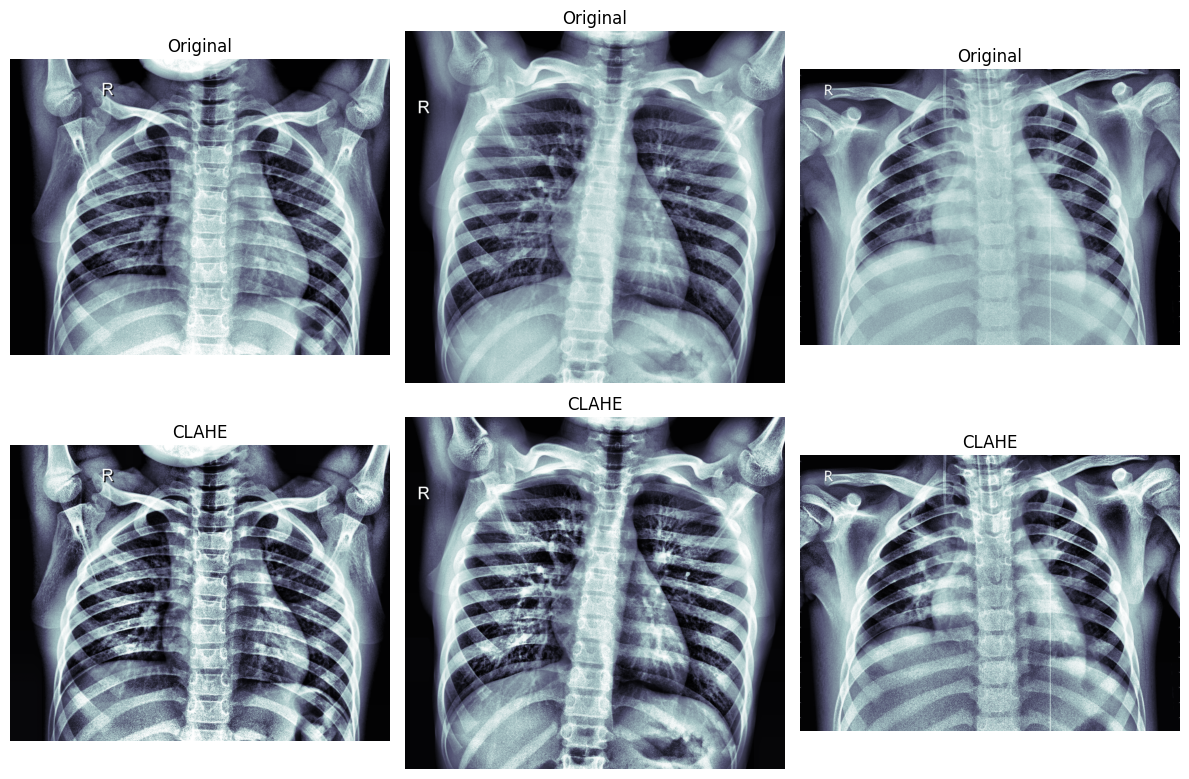

In [11]:
# Comparação do original vs corrigido
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
amostras = df.sample(3, random_state=42)

for col, (_, row) in enumerate(amostras.iterrows()):
    img_original = Image.open(row['filepath'])
    img_corrigida = corrigir_brilho(row['filepath'])

    axes[0, col].imshow(img_original,  cmap='bone')
    axes[0, col].set_title('Original')
    axes[0, col].axis('off')

    axes[1, col].imshow(img_corrigida, cmap='bone')
    axes[1, col].set_title('CLAHE')
    axes[1, col].axis('off')

plt.tight_layout()
plt.show()

A correção de brilho é nítida, o que melhora a capacidade do modelo de aprender a diferenciar casos normais de com pneumonia.

###Corte de bordas

In [12]:
# Como visto na EDA, há informações tendenciosas na borda
# Elementos como o R ou L na borda devem ser cortados

# A margem é percentual, foi adaptada para cortar apenas o necessário
# Vale ressaltar que isso só é possível,
# pois a área que mais influência na classificação é o centro, não as bordas
def crop_central(img, margem=0.08):
    w, h = img.size
    left = int(w * margem)
    right = int(w * (1 - margem))
    top = int(h * margem)
    bottom = int(h * (1 - margem))
    return img.crop((left, top, right, bottom))

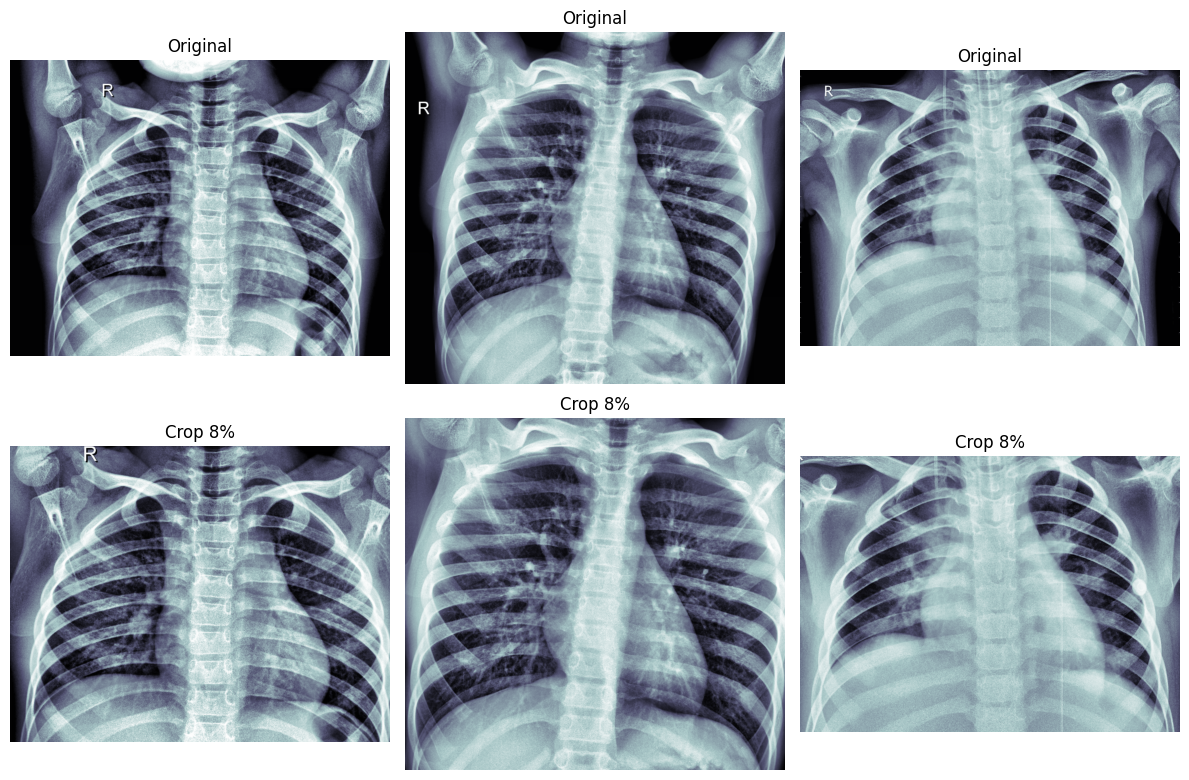

In [13]:
# Comparação para definir a melhor margem
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
amostras = df.sample(3, random_state=42)

for col, (_, row) in enumerate(amostras.iterrows()):
    img_original = Image.open(row['filepath'])
    img_cropada = crop_central(img_original)

    axes[0, col].imshow(img_original, cmap='bone')
    axes[0, col].set_title('Original')
    axes[0, col].axis('off')

    axes[1, col].imshow(img_cropada, cmap='bone')
    axes[1, col].set_title('Crop 8%')
    axes[1, col].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Corte em todo o dataset
for _, row in df.iterrows():
    img = Image.open(row['filepath'])
    img_cropada = crop_central(img)

    label_dir = os.path.join(output_dir, row['label'])
    os.makedirs(label_dir, exist_ok=True)

    dest = os.path.join(label_dir, row['filename'])
    img_cropada.save(dest)

print("Crop concluído!")

Crop concluído!


###Padronização de tamanho

In [15]:
# Como visto na EDA, as imagens têm tamanhos diferentes
# e o tamanho médio de cada classe é diferente,
# logo a padronização do tamanho foi escolhida,
# e as imagens tendem a ser quadradas,
# as que não são serão completadas com bordas pretas
def padronizar_tamanho(img, tamanho=224):
    # O tamanho 224x224 foi escolhido por ser o tamanho padrão usado em transfer learning
    img.thumbnail((tamanho, tamanho), Image.LANCZOS)

    img_quadrada = ImageOps.pad(img, (tamanho, tamanho), color=0)
    return img_quadrada

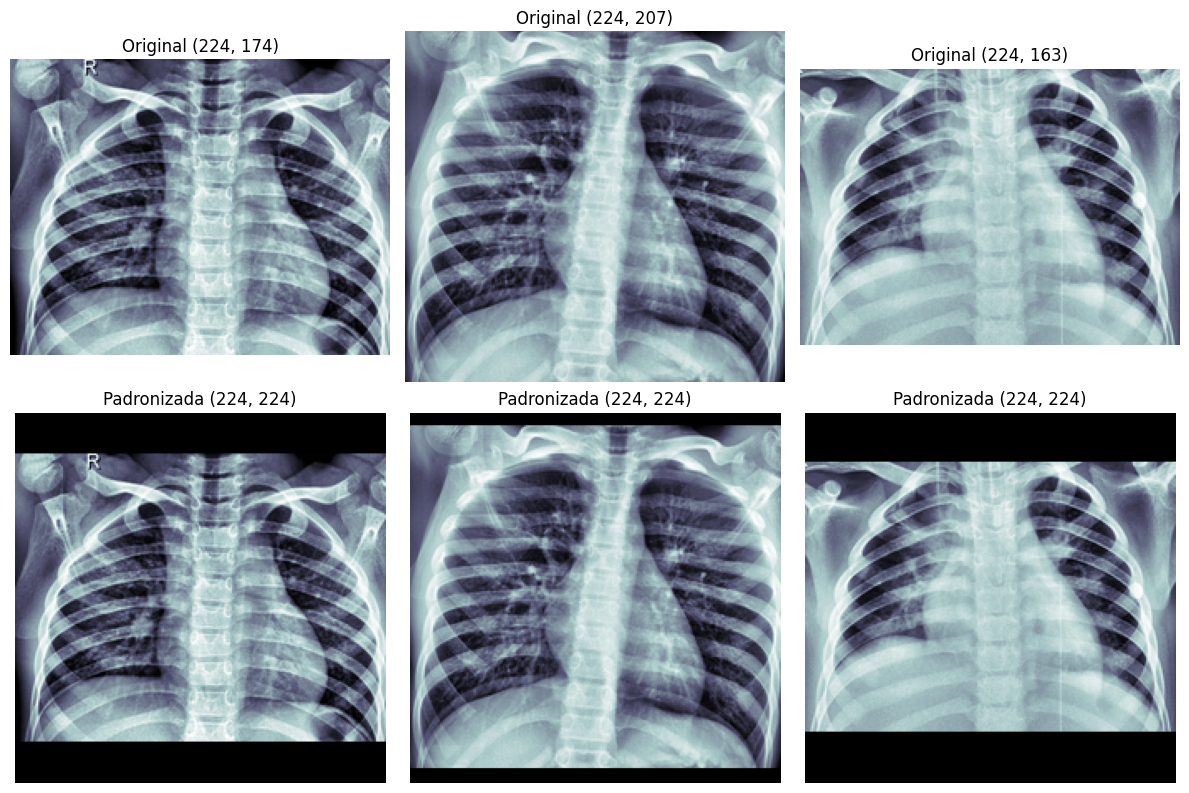

In [16]:
# Comparação com o redimensionamento das imagens
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

amostras = df.sample(3, random_state=42)

for col, (_, row) in enumerate(amostras.iterrows()):
    img_original = Image.open(row['filepath'])
    img_padronizada = padronizar_tamanho(img_original)

    axes[0, col].imshow(img_original, cmap='bone')
    axes[0, col].set_title(f'Original {img_original.size}')
    axes[0, col].axis('off')

    axes[1, col].imshow(img_padronizada, cmap='bone')
    axes[1, col].set_title(f'Padronizada {img_padronizada.size}')
    axes[1, col].axis('off')

plt.tight_layout()
plt.show()

In [17]:
# Padronização em todo o dataset
for _, row in df.iterrows():
    img = Image.open(row['filepath'])
    img_padronizada = padronizar_tamanho(img)

    label_dir = os.path.join(output_dir, row['label'])
    os.makedirs(label_dir, exist_ok=True)

    dest = os.path.join(label_dir, row['filename'])
    img_padronizada.save(dest)

print("Padronização concluída!")

Padronização concluída!


###Balanceamento de classes e class weight

Na EDA, foi relevado que há grande desbalanceamento de classes, sendo que há 2.88 vezes mais exemplos da classe pneumonia do que da classe normal. Isso revela a necessidade de balancear os dados. Para tanto, o OverSampling + Augmentation foi escolhido, pois:
1. Um UnderSampling implicaria na perda de muitos casos de referência, o que não é interessante.
2. Um SMOTE diretamente aplicado poderia gerar imagens confusas, já que o eixo de inclinação não é sempre o mesmo.
3. O uso de Augmentation explora a diversidade do dataset em termos de inclinação, o que melhor se encaixa num contexto real.

Além disso, será aplicado o class weight como reforço, ou seja, o modelo será mais penalizado ao classificar casos com pneumonia como normais. Isso, no contexto médito, é importante, pois um falso negativo pode ser fatal.

O class weight também será definido no notebook de modelagem.

###Salvando o dataframe tratado e os pesos

A modelagem será feita em outro notebook para fins de organização, então as modificações aqui feitas serão armazenadas no drive.

In [18]:
# Salvando o dataframe em csv
df.to_csv('/content/df_train_tratado.csv', index=False)
files.download('/content/df_train_tratado.csv')

# Salvando as imagens alteradas em zip
shutil.make_archive(
    '/content/chest_xray_tratado',
    'zip',
    '/content',
    'chest_xray_tratado',
    )

files.download('/content/chest_xray_tratado.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>